## Constants

In [1]:
MEN_PATH = r'data/men/'
WOMEN_PATH = r'data/women/'

## Import tools

In [198]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from random import randint
import pandas as pd
import pickle
from IPython.display import Image
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

## Loading the data

In [3]:
men_imgs = []
women_imgs = []

In [4]:
#load men data
men_imgs = [MEN_PATH + img for img in os.listdir(MEN_PATH) if img.endswith('.jpg')]

In [5]:
women_imgs = [WOMEN_PATH + img for img in os.listdir(WOMEN_PATH) if img.endswith('.jpg')]

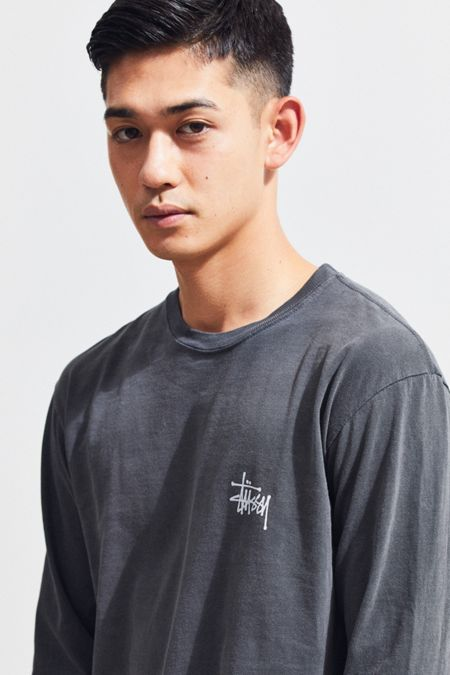

In [6]:
Image(men_imgs[2])

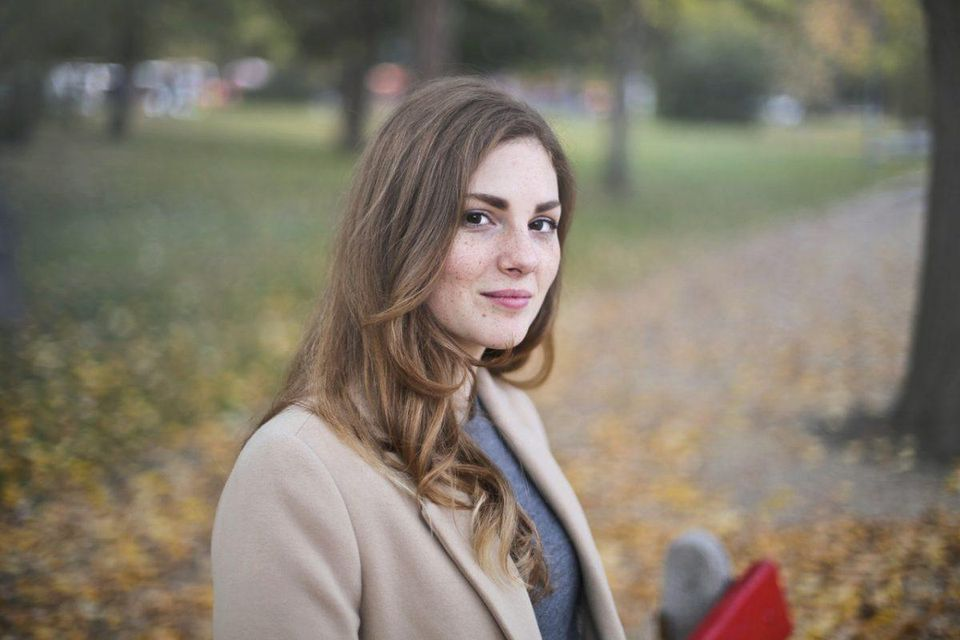

In [7]:
Image(women_imgs[2])

## Data Preprocessing

In [8]:
# How we will convert the image into matrix?

img = load_img(men_imgs[2], target_size=(224,224))
img = np.array(img)
img.shape

(224, 224, 3)

In [9]:
# The model expect 4-D (batchSize, rows, columns, channels), so we will expand more dimension
reshaped_img = img.reshape(1,224,224,3)
reshaped_img.shape

(1, 224, 224, 3)

## Build the model

In [10]:
model = VGG16()
# Remove the output layer, get the features vector only
model = Model(inputs=model.inputs, outputs= model.layers[-2].output)

In [11]:
imgx = preprocess_input(reshaped_img)
feat = model.predict(imgx, use_multiprocessing=True)
feat.shape

(1, 4096)

In [22]:
def feature_exetract(file, model):
    # Load the img
    img = load_img(file, target_size=(224,224,3))
    # Convert the img to array
    img = np.array(img)
    # reshape the data
    reshaped_img = img.reshape(1,224,224,3)
    # Prepare the img for the model
    img_final = preprocess_input(reshaped_img)
    # Get the vector of the features
    features = model.predict(img_final, use_multiprocessing=True)
    # Return the features
    return features

## Convert the data into pandas format

In [26]:
sex_df = pd.DataFrame()

In [ ]:
# Load the features for men dataset
counter = 1
for img in men_imgs:
    feat = feature_exetract(img, model)
    sex_df['MAN_' + str(counter)] = pd.Series(list(feat.T)).explode()
    counter += 1

In [ ]:
counter = 1
for img in women_imgs:
    feat = feature_exetract(img, model)
    sex_df['WOMEN' + str(counter)] = pd.Series(list(feat.T)).explode()
    counter += 1

In [39]:
sex_df.head()

,MAN_1,MAN_2,MAN_3,MAN_4,MAN_5,MAN_6,MAN_7,MAN_8,MAN_9,MAN_10,...,WOMEN1698,WOMEN1699,WOMEN1700,WOMEN1701,WOMEN1702,WOMEN1703,WOMEN1704,WOMEN1705,WOMEN1706,WOMEN1707
0,0.0,1.559717,0.026423,0.025994,0.0,0.0,0.451783,0.0,0.500092,0.0,...,0.0,0.0,0.0,0.0,0.0,0.604824,0.0,1.593391,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.218686,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.305876,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.174532,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.601339,0.0,0.0,0.0,1.397366,0.109554,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.859666,...,0.0,0.0,0.0,1.472945,0.0,0.0,0.0,0.0,0.367794,5.646127


In [40]:
tsne_projection = TSNE(n_components=2, 
                       perplexity=2.5, 
                       learning_rate=1, 
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=-1, 
                       n_iter=10**4, 
                       random_state=0).fit_transform(sex_df.T) # Transpose the dataframe to label the images


F:\PROGRAMS\Programming\anaconda\envs\DS\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [81]:
# Make the projection as a data-frame
tsne_df = pd.DataFrame(tsne_projection, index=sex_df.columns)
tsne_df.shape

(2994, 2)

In [82]:
tsne_df.head()

,0,1
MAN_1,-0.358107,106.053314
MAN_2,37.445312,70.027985
MAN_3,71.462387,30.597538
MAN_4,25.009029,-0.625583
MAN_5,3.827109,99.597969


In [83]:
sample_df = pd.concat([tsne_df.iloc[:100, :], tsne_df.iloc[2000:2100, :]], axis=0)

In [84]:
fig = px.scatter(x=sample_df[0], y=sample_df[1], text=sample_df.index)
fig.update_traces(textposition='top center')
fig.update_layout(height=900, width=1200, title_text='TSNE')
fig.show()

## Build the clustering model

In [256]:
cluster_model = DBSCAN(eps=3, min_samples=10, algorithm='brute', metric='manhattan')
cluster_labels = cluster_model.fit_predict(tsne_df) # fit the model

F:\PROGRAMS\Programming\anaconda\envs\DS\lib\site-packages\sklearn\utils\validation.py:1692: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [257]:
tsne_df['cluster'] = cluster_labels

In [258]:
tsne_df.head(10)

,0,1,cluster
MAN_1,-0.358107,106.053314,-1
MAN_2,37.445312,70.027985,-1
MAN_3,71.462387,30.597538,-1
MAN_4,25.009029,-0.625583,-1
MAN_5,3.827109,99.597969,-1
MAN_6,12.008938,58.968624,-1
MAN_7,19.754232,76.787247,-1
MAN_8,18.381405,110.505737,-1
MAN_9,112.363663,-29.944239,-1
MAN_10,91.448418,-1.014488,-1


In [263]:
sample_df = pd.concat([tsne_df.iloc[:50, :], tsne_df.iloc[2000:2050, :]], axis=0)

In [264]:
sample_df.sort_values(by='cluster', ascending=True)

,0,1,cluster
MAN_1,-0.358107,106.053314,-1
WOMEN733,12.821177,-12.984728,-1
WOMEN732,41.270653,-10.047379,-1
WOMEN729,-21.786934,81.040657,-1
WOMEN728,-46.590927,-32.777180,-1
...,...,...,...
MAN_38,12.906305,33.532692,6
WOMEN731,12.235551,32.080666,6
WOMEN750,-15.950397,-39.861107,7
WOMEN751,-47.958225,-58.909943,10


In [265]:
# Plot the new clusters
fig = px.scatter(x=sample_df[0], y=sample_df[1], text=sample_df.index, color=sample_df['cluster'])
fig.update_traces(textposition='top center')
fig.update_layout(height=800, width=800, title_text='Sex clustering')
fig.show()

## Interpreting the results and the clusters
Maybe you wondering, why all this clusters?<br>
Actullay this splits or clusters not depending on gender only, it maybe looking for haircut!<br>
for example: a girl who has a shor haircut like a men, and vice-versa<br><br>

Maybe the there is something weird in the images, like the one i'll show below this cell<br>the features of the image will get a different way not the gender way as we want

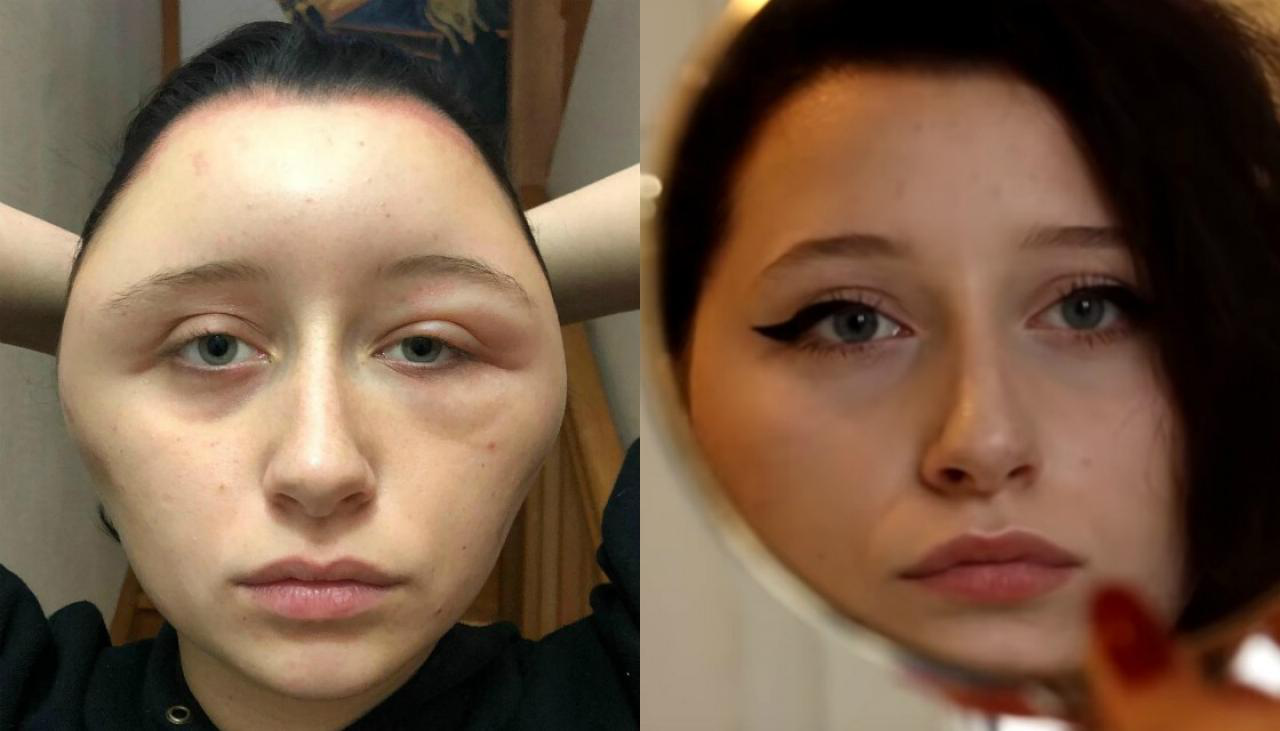

In [266]:
load_img(women_imgs[750])

It was a good practice to see the result of the clustering and unsupervised learning with Images<br>
but it's not the best practice when we talk about 'sex classification'